In this project, I will use Scikit-learn to implement multiclass classification with logistic regression by first preparing your data (including one-hot encoding if needed), then training models using both One-vs-All (OvA) and One-vs-One (OvO) strategies. After splitting the data into training and testing sets, I'll fit the models, make predictions, and evaluate performance using metrics like accuracy, precision, recall, F1-score, and a confusion matrix to understand how well each strategy performs.

In [3]:
#import libraries 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [4]:
file_path = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/GkDzb7bWrtvGXdPOfk6CIg/Obesity-level-prediction-dataset.csv"
data = pd.read_csv(file_path)
data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


### exploratory data analysis 


Visualize the distribution of the target variable to understand the class balance.



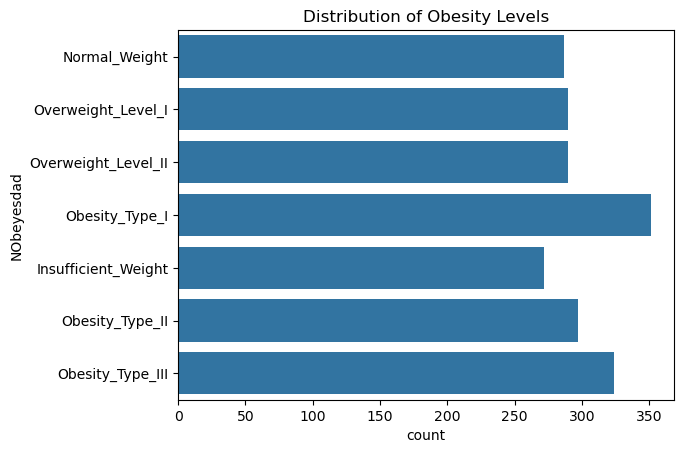

In [5]:
# Distribution of target variable
sns.countplot(y='NObeyesdad', data=data)
plt.title('Distribution of Obesity Levels')
plt.show()


From this we can see that the dataset is fairly balanced and soes not require  any special attention in terms of biased training

In [7]:
data.info

<bound method DataFrame.info of       Gender        Age    Height      Weight family_history_with_overweight  \
0     Female  21.000000  1.620000   64.000000                            yes   
1     Female  21.000000  1.520000   56.000000                            yes   
2       Male  23.000000  1.800000   77.000000                            yes   
3       Male  27.000000  1.800000   87.000000                             no   
4       Male  22.000000  1.780000   89.800000                             no   
...      ...        ...       ...         ...                            ...   
2106  Female  20.976842  1.710730  131.408528                            yes   
2107  Female  21.982942  1.748584  133.742943                            yes   
2108  Female  22.524036  1.752206  133.689352                            yes   
2109  Female  24.361936  1.739450  133.346641                            yes   
2110  Female  23.664709  1.738836  133.472641                            yes   

     FA

In [9]:
data.isnull().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

### Preprocessing data 

#### Scaling data

Scale the numerical features to standardize their ranges for better model performance.

In [10]:
#Standardizing continuous numerical features
continuous_columns = data.select_dtypes(include=['float64']).columns.tolist()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[continuous_columns])

# Converting to a DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=scaler.get_feature_names_out(continuous_columns))

# Combining with the original dataset
scaled_data = pd.concat([data.drop(columns=continuous_columns), scaled_df], axis=1)

### One hot coding

In [11]:
#identifyimg categorical colmns
# Identifying categorical columns
categorical_columns = scaled_data.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('NObeyesdad')  # Exclude target column

# Applying one-hot encoding
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = encoder.fit_transform(scaled_data[categorical_columns])

# Converting to a DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))

# Combining with the original dataset
prepped_data = pd.concat([scaled_data.drop(columns=categorical_columns), encoded_df], axis=1)

In [12]:
### Encode the target
# Encoding the target variable
prepped_data['NObeyesdad'] = prepped_data['NObeyesdad'].astype('category').cat.codes
prepped_data.head()

,NObeyesdad,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,...,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,1,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,5,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,6,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Separate the input data and target data


In [15]:
# Preparing final dataset
X=prepped_data.drop('NObeyesdad',axis=1)
y=prepped_data['NObeyesdad']


### Model training

#### Splitiing the data set


In [ ]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Logistic Regression with One-vs-All

In [17]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Training logistic regression model using One-vs-All (default)
model_ova = LogisticRegression(multi_class='ovr', max_iter=1000)
model_ova.fit(X_train, y_train)
# Predictions
y_pred_ova = model_ova.predict(X_test)

# Evaluation metrics for OvA
print("One-vs-All (OvA) Strategy")
print(f"Accuracy: {np.round(100*accuracy_score(y_test, y_pred_ova),2)}%")

One-vs-All (OvA) Strategy
Accuracy: 76.12%


### Logistic Regression with OvO

In [18]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Training logistic regression model using One-vs-One
model_ovo = OneVsOneClassifier(LogisticRegression(max_iter=1000))
model_ovo.fit(X_train, y_train)
# Predictions
y_pred_ovo = model_ovo.predict(X_test)

# Evaluation metrics for OvO
print("One-vs-One (OvO) Strategy")
print(f"Accuracy: {np.round(100*accuracy_score(y_test, y_pred_ovo),2)}%")

One-vs-One (OvO) Strategy
Accuracy: 92.2%


In [20]:
#Experiment with different train test size
for test_size in [0.1, 0.3]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    model_ova.fit(X_train, y_train)
    y_pred = model_ova.predict(X_test)
    print(f"Test Size: {test_size}")
    print("Accuracy:", accuracy_score(y_test, y_pred))

Test Size: 0.1
Accuracy: 0.7594339622641509
Test Size: 0.3
Accuracy: 0.749211356466877


In [ ]:
#